# Dentate Gyrus

This processed Dentate Gyrus data set is downloaded from scVelo package, which is a very nice tool for RNA velocity quantification. Here, we will illustrate that the differential momentum genes could reveal biological informed trajectory, thanks to its supervised manner on informative gene detection. 

You can run this notebook with our pre-computed data, which can be found [here](https://sourceforge.net/projects/brie-rna/files/examples/dentateGyrus/). You can also download it by using the following command line and unzip it into the `./data` folder:
```
wget http://ufpr.dl.sourceforge.net/project/brie-rna/examples/dentateGyrus/brie2_dentateGyrus.zip
unzip -j brie2_dentateGyrus.zip -d ./data
```

In [1]:
import brie
import numpy as np
import scanpy as sc
import scvelo as scv
import matplotlib.pyplot as plt
scv.logging.print_version()

Running scvelo 0.2.1 (python 3.7.6) on 2020-11-04 14:20.


In [2]:
scv.settings.verbosity = 3  # show errors(0), warnings(1), info(2), hints(3)
scv.settings.presenter_view = True  # set max width size for presenter view
scv.set_figure_params('scvelo')  # for beautified visualization

In [3]:
# define the path you store the example data
# dat_dir = "./data"
dat_dir = "/home/yuanhua/research/brie2/releaseDat/dentateGyrus/"

## scVelo's default results

#### Fitting scVelo
Scvelo's stochastic and dynamical models may take a few minutes to run, so we pre-run it by the following codes.

*Stochastic model*
```Python
adata = scv.datasets.dentategyrus()

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.velocity(adata)
scv.tl.velocity_graph(adata)
adata.write(dat_dir + "/dentategyrus_scvelo_stoc_3K.h5ad")
```

In [4]:
adata = scv.read(dat_dir + "/dentategyrus_scvelo_stoc_3K.h5ad")

In [5]:
scv.utils.show_proportions(adata)
adata

Abundance of ['spliced', 'unspliced']: [0.9 0.1]


AnnData object with n_obs × n_vars = 2930 × 2894
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
    var: 'velocity_gamma', 'velocity_r2', 'velocity_genes'
    uns: 'clusters_colors', 'neighbors', 'pca', 'velocity_graph', 'velocity_graph_neg', 'velocity_params'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'spliced', 'unspliced', 'variance_velocity', 'velocity'
    obsp: 'connectivities', 'distances'

In [6]:
print(np.sum(adata.var['velocity_genes']))

634


computing velocity graph
    finished (0:00:10) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


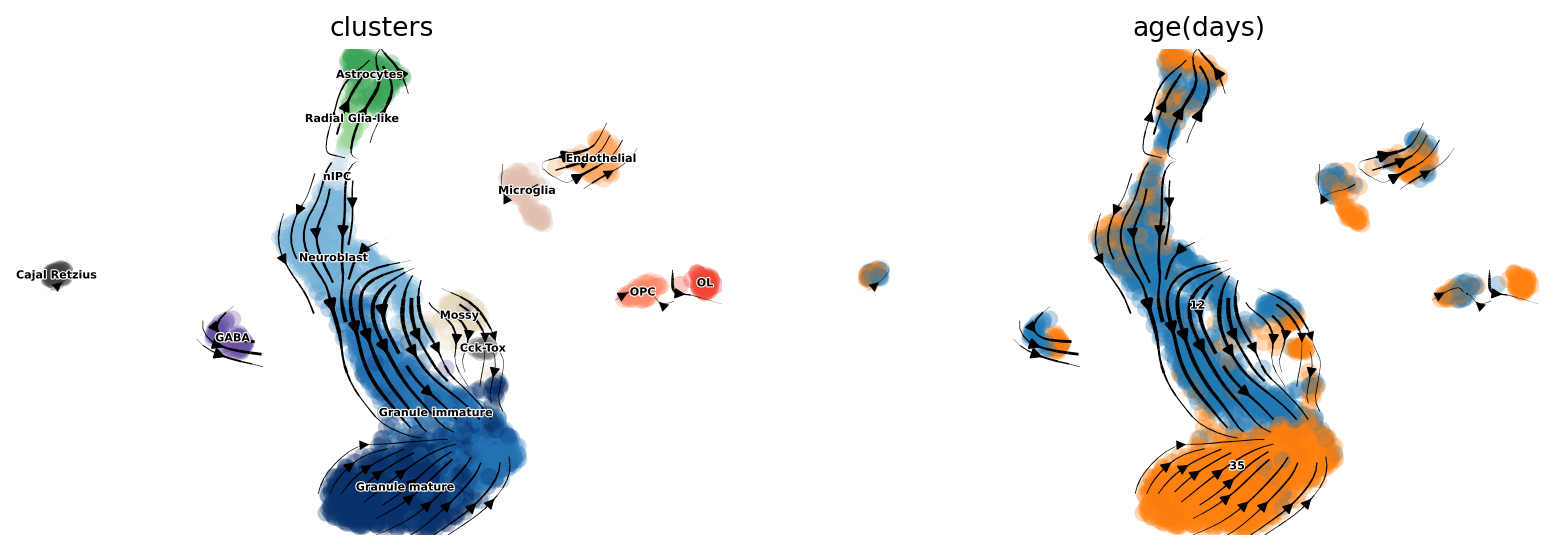

In [7]:
scv.tl.velocity_graph(adata, gene_subset=None)
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color=['clusters', 'age(days)'],
                                 legend_fontsize=5)

In [8]:
## Plotting with higher figure resolution 

# scv.pl.velocity_embedding_stream(adata, basis='umap', color=['clusters'], 
#                                  legend_fontsize=5, dpi=150, title='')

# scv.pl.velocity_embedding(adata, basis='umap', arrow_length=2, arrow_size=2, dpi=300, title='')

## BRIE2's differential momentum genes (DMGs)

Here, we aim to use BRIE2 to detect the differential momentum genes between cell types and illustrate its performance on projecting RNA velocity to cellular transitions.

The command line and design matrix are: [run_brie2.sh](https://github.com/huangyh09/brie-tutorials/blob/main/dentateGyrus/run_brie2.sh) and [dentategyrus_cluster_OL.tsv](https://github.com/huangyh09/brie-tutorials/blob/main/dentateGyrus/data/dentategyrus_cluster_OL.tsv).

### DMGs between OPC and OL

One main differentiation is between OPC and OL. So, we took out these 103 cells and run BRIE2 to detect the DMGs by testing the covariate `is_OL`.

In [9]:
adata_brie_OL = scv.read(dat_dir + "/brie_dentategyrus_cluster_subOL.h5ad")
adata_OL = adata[adata_brie_OL.obs.index, :]

Vocalno plot for DMGs between OPC and OL. cell_ceoff means effect size on logit(Psi), Psi means proportion of spliced RNAs. Positive effect size means OL has higher proportion of spliced RNAs.

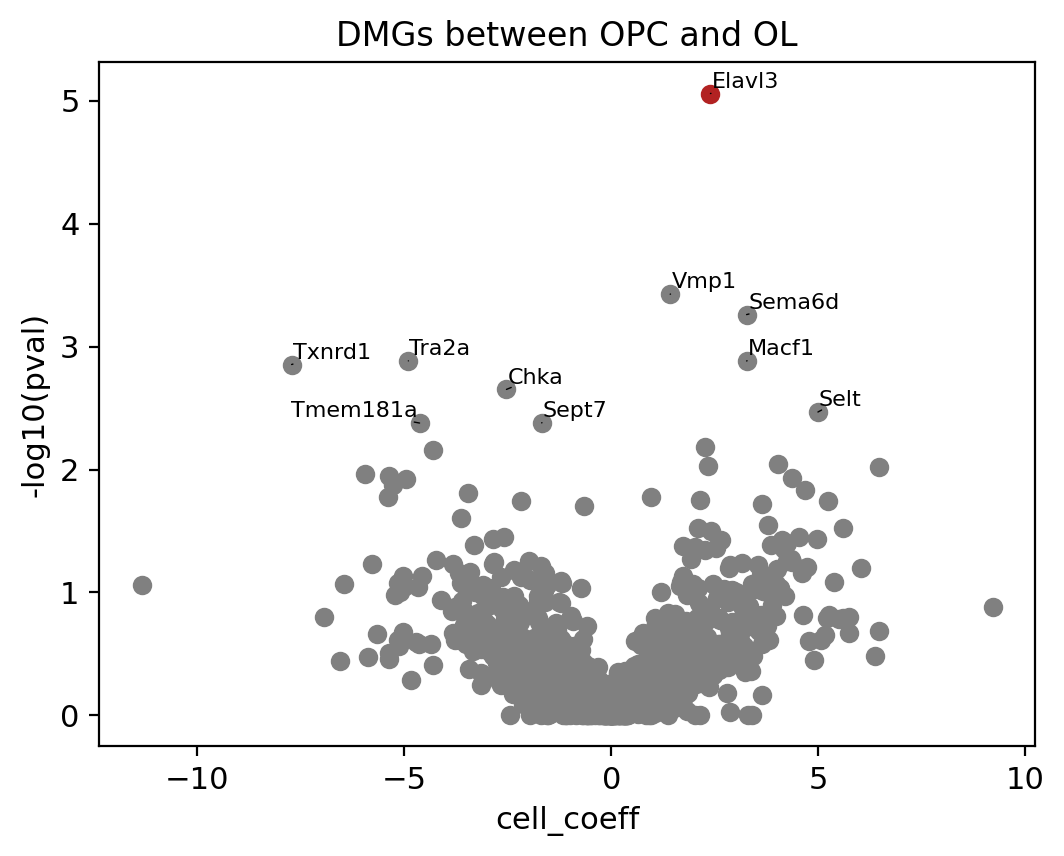

In [10]:
plt.figure(figsize=(6, 4.5))
brie.pl.volcano(adata_brie_OL)
plt.title('DMGs between OPC and OL')
# plt.savefig(dat_dir + '../../brie2/figures/fig_s11_vocalno_DMG_OPCvsOL.pdf', dpi=150)

In [11]:
top_genes_OL = adata_brie_OL.var.index[np.argsort(list(np.min(adata_brie_OL.varm['fdr'], axis=1)))[:100]]
top_genes_OL[:4]

Index(['Elavl3', 'Sema6d', 'Vmp1', 'Tra2a'], dtype='object', name='index')

index
Elavl3    0.310708
Sema6d   -0.358877
Vmp1     -0.736003
Tra2a    -1.474734
Name: velocity_r2, dtype: float64


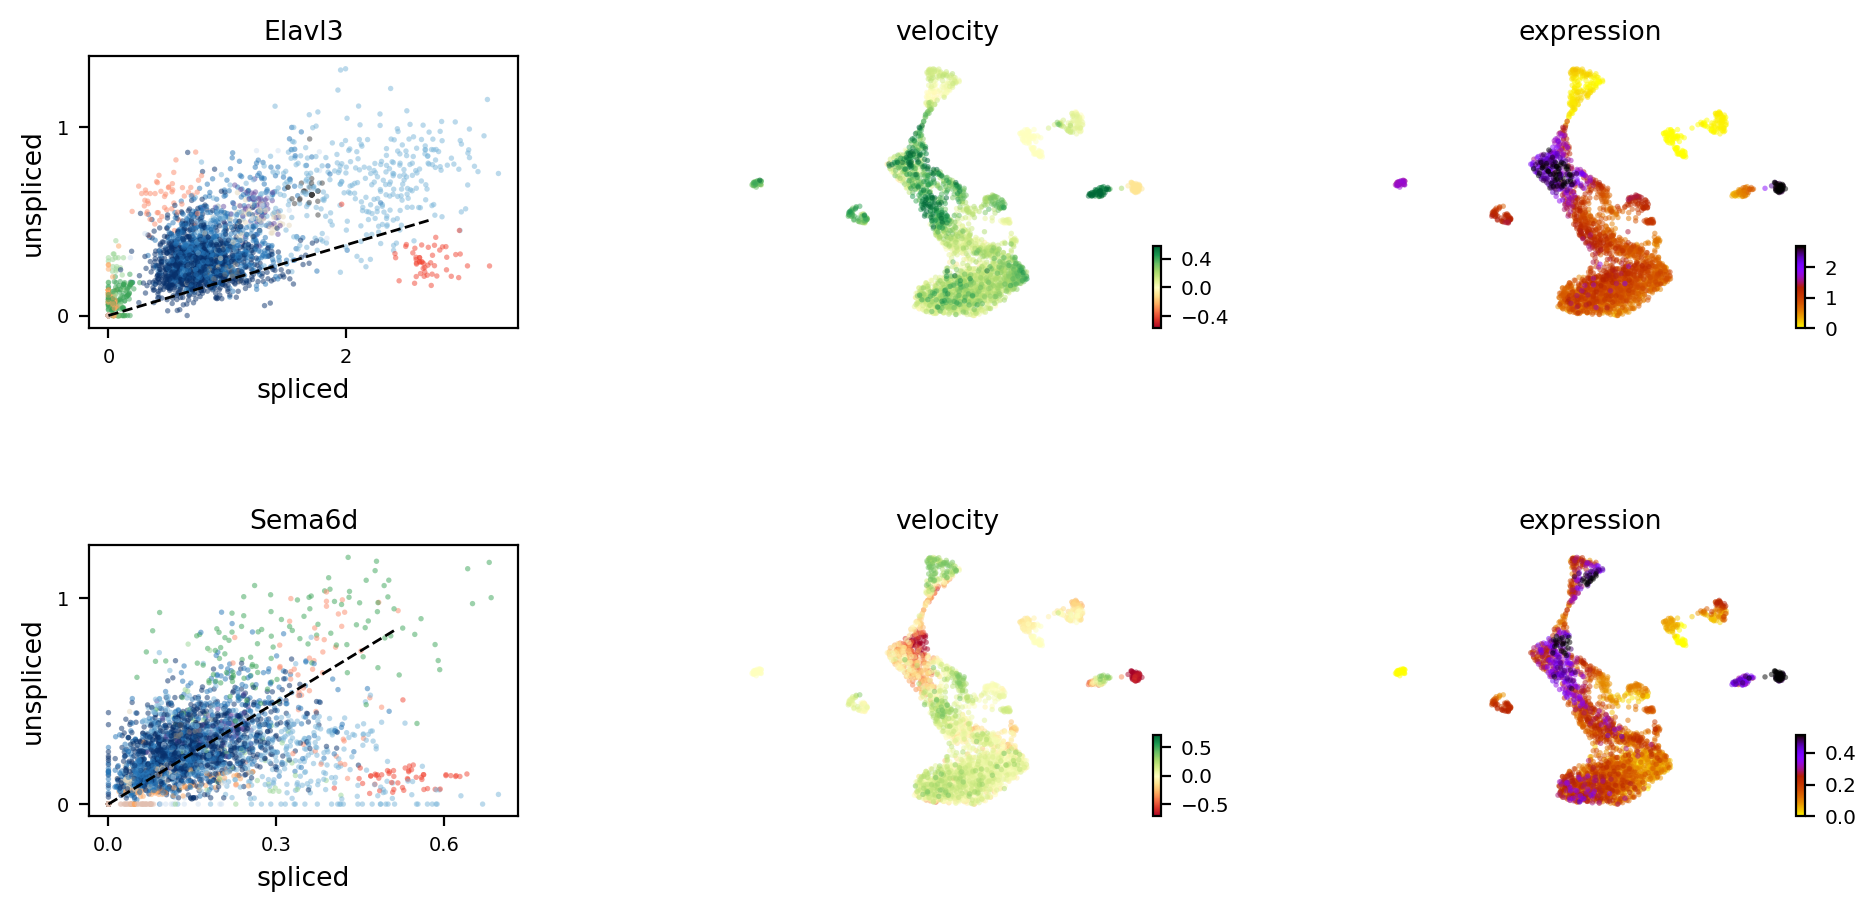

In [12]:
print(adata.var['velocity_r2'][top_genes_OL[:4]])

fig = plt.figure(figsize=(11, 5))
ax = plt.plot(1,1,1)
scv.pl.velocity(adata, var_names=top_genes_OL[:2], colorbar=True, ncols=1, ax=ax, show=False)
# plt.savefig(dat_dir + '../../brie2/figures/fig_s11_OPLvsOL_DMG.png', dpi=150)
plt.show()

48 48
computing velocity graph


Trying to set attribute `.uns` of view, copying.


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


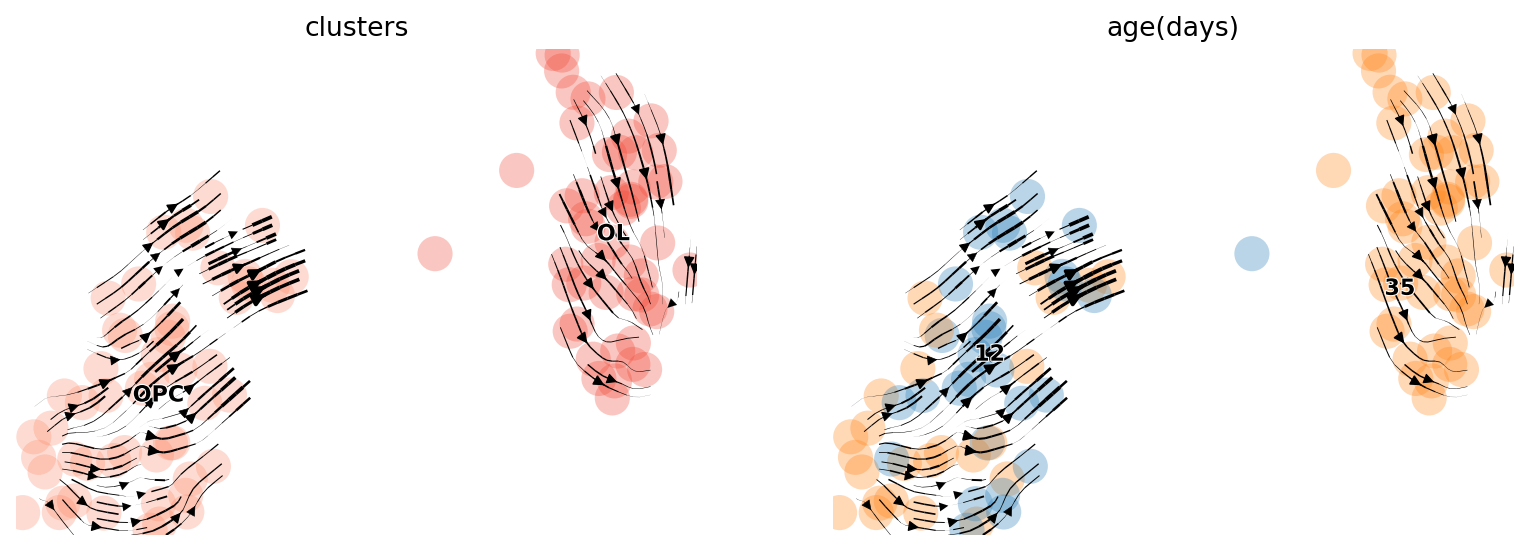

In [13]:
idx = adata_brie_OL.varm['ELBO_gain'][:, 0] > 2
gene_use = adata_brie_OL.var.index[idx]

print(len(gene_use), sum(brie.match(gene_use, adata_OL.var.index) != None))

scv.tl.velocity_graph(adata_OL, gene_subset=gene_use)
scv.pl.velocity_embedding_stream(adata_OL, basis='umap', 
                                 color=['clusters', 'age(days)'],
                                 legend_fontsize=10, dpi=100, size=1000)

634
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
15 15
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
48 48
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
116 116
computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap',

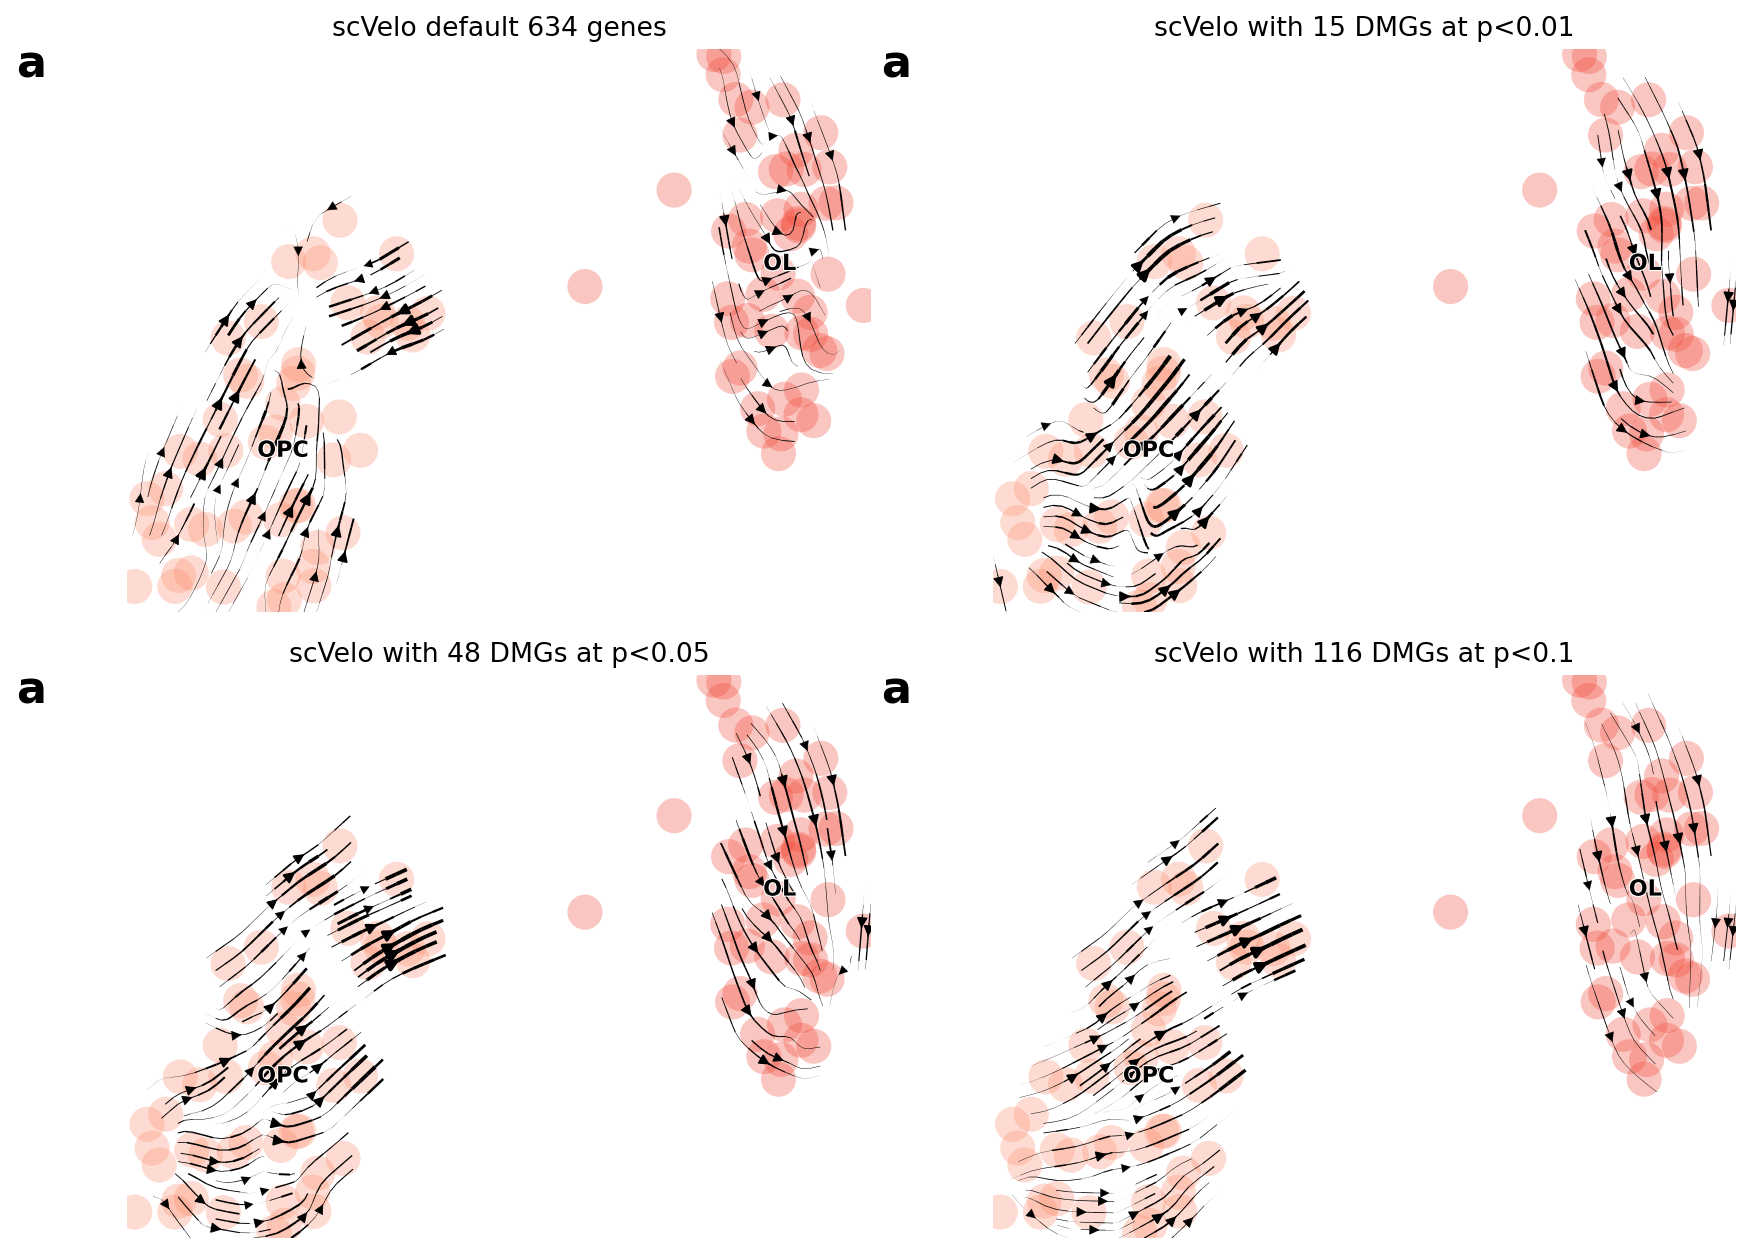

In [14]:
fig = plt.figure(figsize=(11, 8), dpi=80)
## cutoff 0.001
ax1 = plt.subplot(2, 2, 1)

print(np.sum(adata_OL.var['velocity_genes']))
idx1 = adata_OL.var['velocity_genes']
scv.tl.velocity_graph(adata_OL, gene_subset=None)
scv.pl.velocity_embedding_stream(adata_OL, basis='umap', color=['clusters'], 
                                 ax=ax1, show=False, legend_fontsize=10, 
                                 size=1000, title='scVelo default %d genes' %(sum(idx1)))
ax1.text(-0.15, 0.95, 'a', transform=ax1.transAxes, size=20, weight='bold')

## cutoff 0.05
ax1 = plt.subplot(2, 2, 2)
idx1 = adata_brie_OL.varm['pval'][:, 0] < 0.01
gene_use1 = adata_brie_OL.var.index[idx1]
print(sum(idx1), sum(brie.match(gene_use1, adata_OL.var.index) != None))

scv.tl.velocity_graph(adata_OL, gene_subset=gene_use1)
scv.pl.velocity_embedding_stream(adata_OL, basis='umap', color=['clusters'], 
                                 ax=ax1, show=False, legend_fontsize=10, 
                                 size=1000, title='scVelo with %d DMGs at p<0.01' %(sum(idx1)))
ax1.text(-0.15, 0.95, 'a', transform=ax1.transAxes, size=20, weight='bold')

## cutoff 0.05
ax1 = plt.subplot(2, 2, 3)

idx1 = adata_brie_OL.varm['pval'][:, 0] < 0.05
gene_use1 = adata_brie_OL.var.index[idx1]
print(sum(idx1), sum(brie.match(gene_use1, adata_OL.var.index) != None))

scv.tl.velocity_graph(adata_OL, gene_subset=gene_use1)
scv.pl.velocity_embedding_stream(adata_OL, basis='umap', color=['clusters'], 
                                 ax=ax1, show=False, legend_fontsize=10, 
                                 size=1000, title='scVelo with %d DMGs at p<0.05' %(sum(idx1)))
ax1.text(-0.15, 0.95, 'a', transform=ax1.transAxes, size=20, weight='bold')

## cutoff 0.05
ax1 = plt.subplot(2, 2, 4)
idx1 = adata_brie_OL.varm['pval'][:, 0] < 0.1
gene_use1 = adata_brie_OL.var.index[idx1]
print(sum(idx1), sum(brie.match(gene_use1, adata_OL.var.index) != None))

scv.tl.velocity_graph(adata_OL, gene_subset=gene_use1)
scv.pl.velocity_embedding_stream(adata_OL, basis='umap', color=['clusters'], 
                                 ax=ax1, show=False, legend_fontsize=10, 
                                 size=1000, title='scVelo with %d DMGs at p<0.1' %(sum(idx1)))
ax1.text(-0.15, 0.95, 'a', transform=ax1.transAxes, size=20, weight='bold')


plt.tight_layout()
# plt.savefig(dat_dir + '../../brie2/figures/fig_s12_OPLvsOL_direction.png', dpi=300)
plt.show()

### DMGs for one cell type vs the rest
We then detect the DMGs for each cell type vs the rest and use them to explore their impact on cellular transitions.

In [15]:
adata_brie = scv.read(dat_dir + "/brie_dentategyrus_cluster.h5ad")
cdr = np.array((adata_brie.X > 0).mean(0))[0, :]

adata_brie

AnnData object with n_obs × n_vars = 2930 × 2879
    obs: 'clusters', 'age(days)', 'clusters_enlarged', 'initial_size_spliced', 'initial_size_unspliced', 'initial_size'
    var: 'n_counts', 'n_counts_uniq', 'loss_gene'
    uns: 'Xc_ids', 'brie_losses', 'brie_param', 'brie_version', 'clusters_colors'
    obsm: 'X_umap', 'Xc'
    varm: 'ELBO_gain', 'cell_coeff', 'fdr', 'intercept', 'pval', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'spliced', 'unspliced'

In [16]:
top_genes_brie = adata_brie.var.index[np.argsort(list(np.min(adata_brie.varm['fdr'], axis=1)))[:100]]
top_genes_brie[:4]

Index(['Celf2', 'Vmp1', 'Myl6', 'Snap25'], dtype='object', name='index')

index
Celf2     0.318048
Vmp1     -0.736003
Myl6      0.338808
Snap25   -0.970810
Name: velocity_r2, dtype: float64


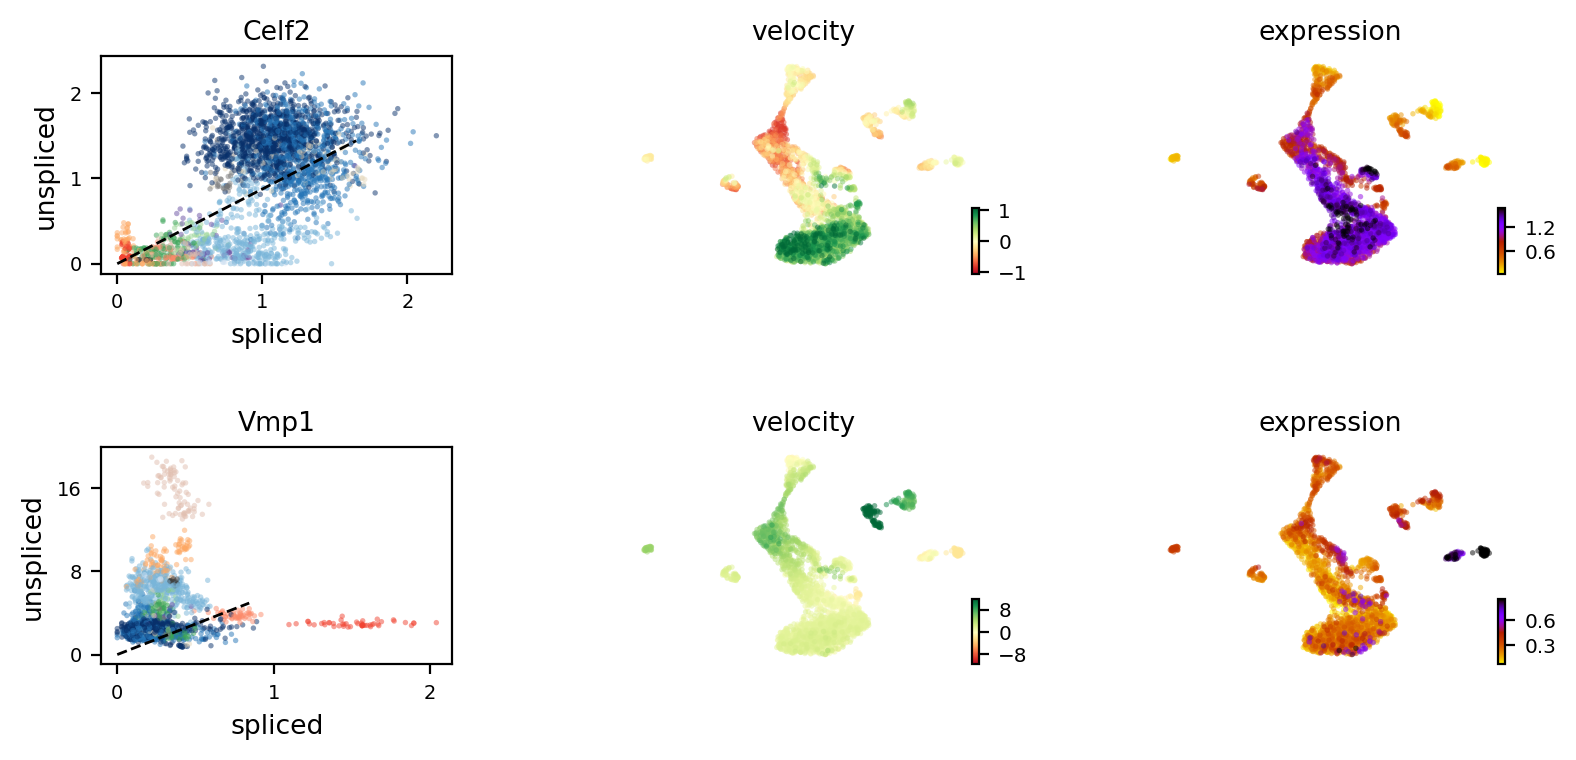

In [17]:
print(adata.var['velocity_r2'][top_genes_brie[:4]])
scv.pl.velocity(adata, var_names=top_genes_brie[:2], colorbar=True, ncols=1)

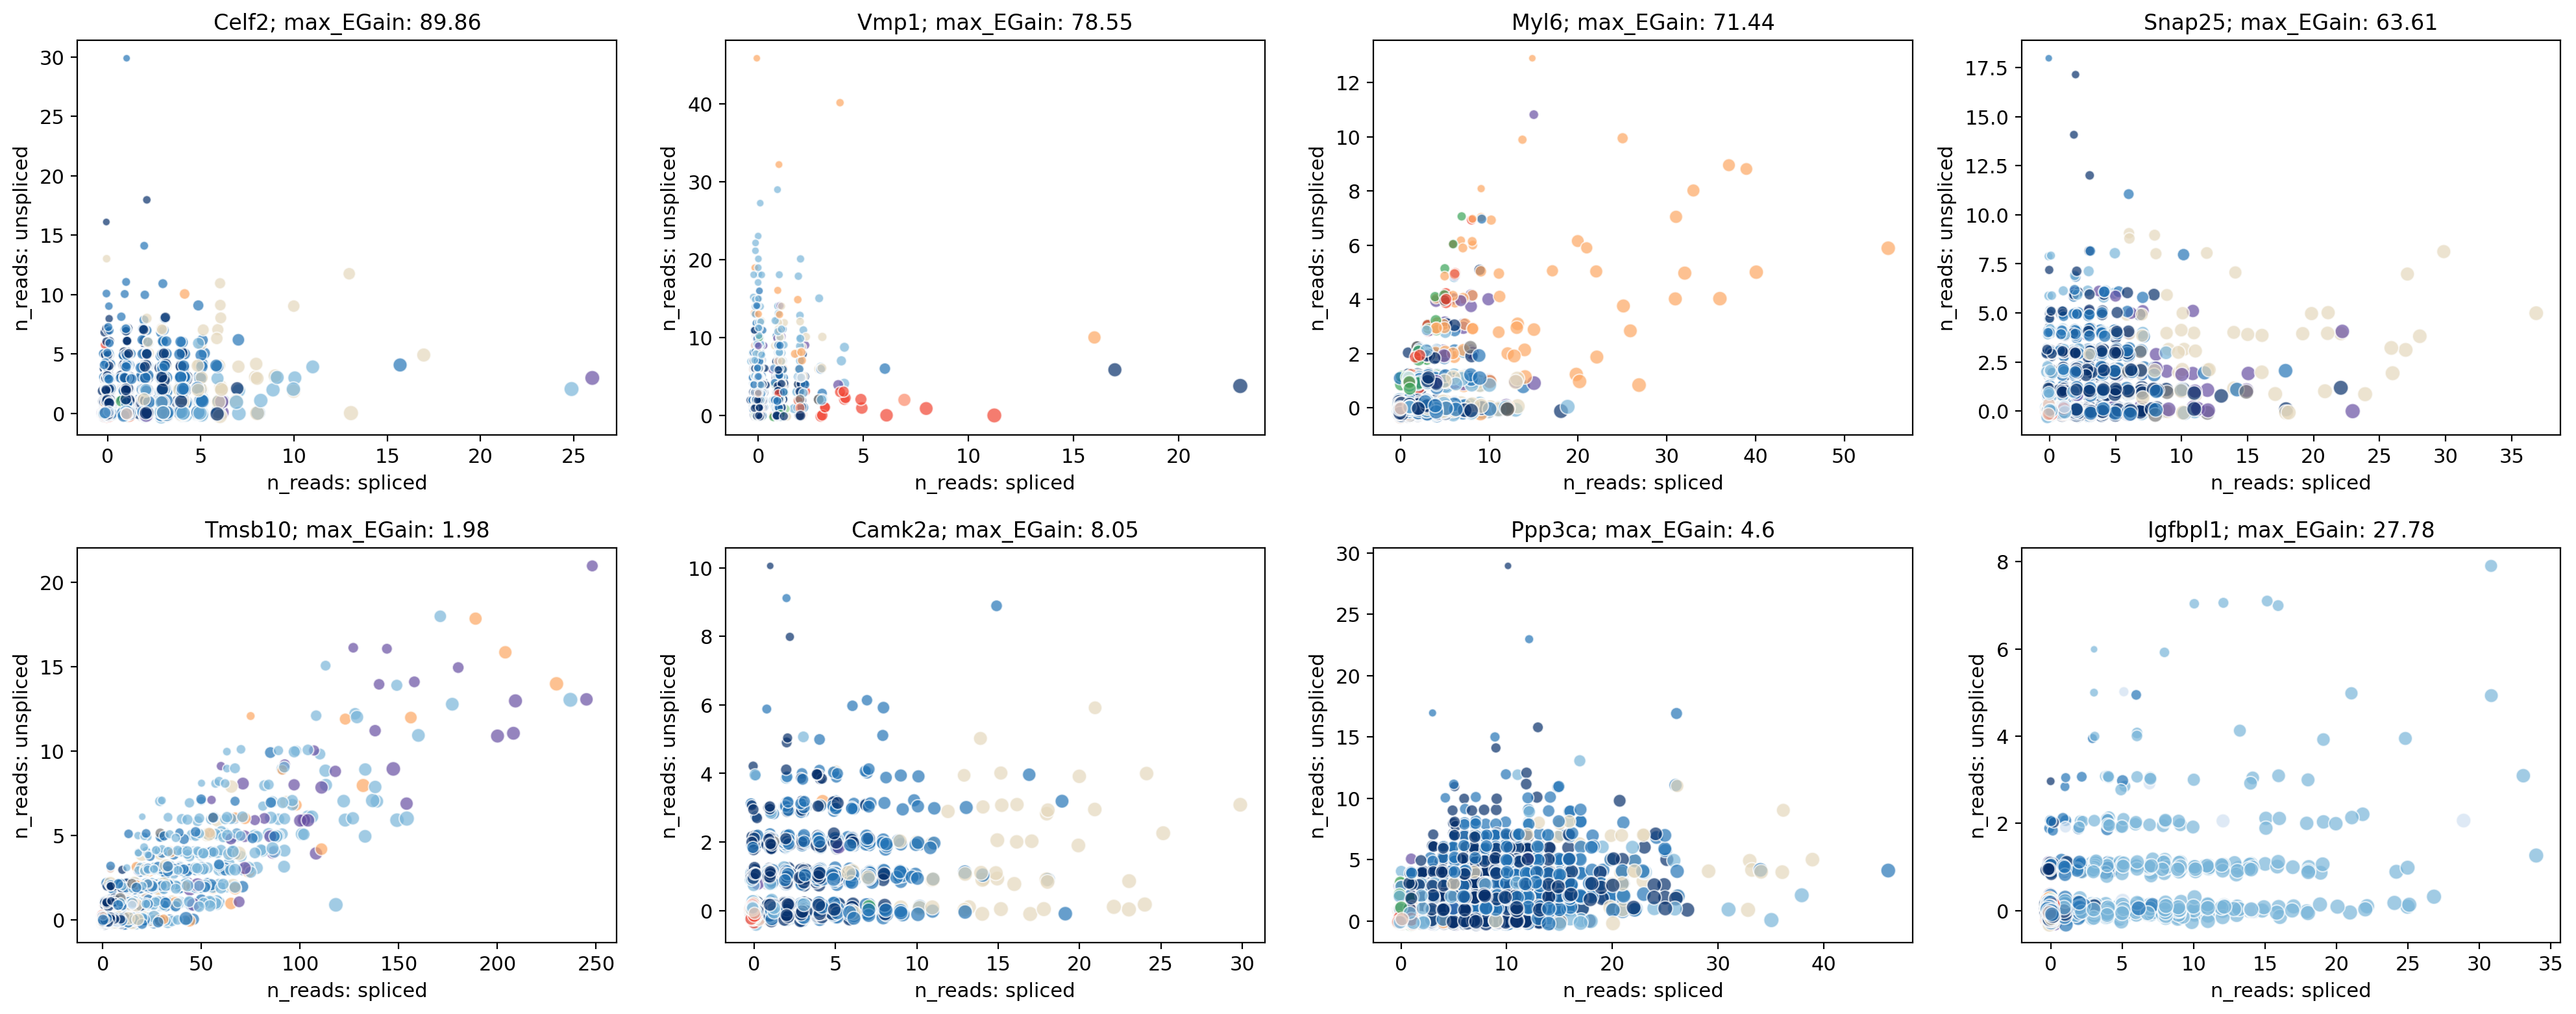

In [18]:
import seaborn as sns

scVelo_genes = ['Tmsb10', 'Camk2a', 'Ppp3ca', 'Igfbpl1']
adata_brie.varm['max_EGain'] = np.round(np.max(adata_brie.varm['ELBO_gain'], axis=1, keepdims=True), 2)

fig = plt.figure(figsize=(20, 8))
brie.pl.counts(adata_brie, genes=np.append(top_genes_brie[:4], scVelo_genes), 
               layers=['spliced', 'unspliced'],
               color='clusters', add_val='max_EGain', 
               nrow=2, alpha=0.7, legend=False,
               palette=sns.color_palette(adata_brie.uns['clusters_colors']),
               hue_order=np.unique(adata_brie.obs['clusters']), noise_scale=0.1)

# plt.savefig(dat_dir + '../../brie2/figures/fig_s10_DMG_counts.png', dpi=200)
plt.show()

335 335
computing velocity graph
    finished (0:00:05) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:02) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


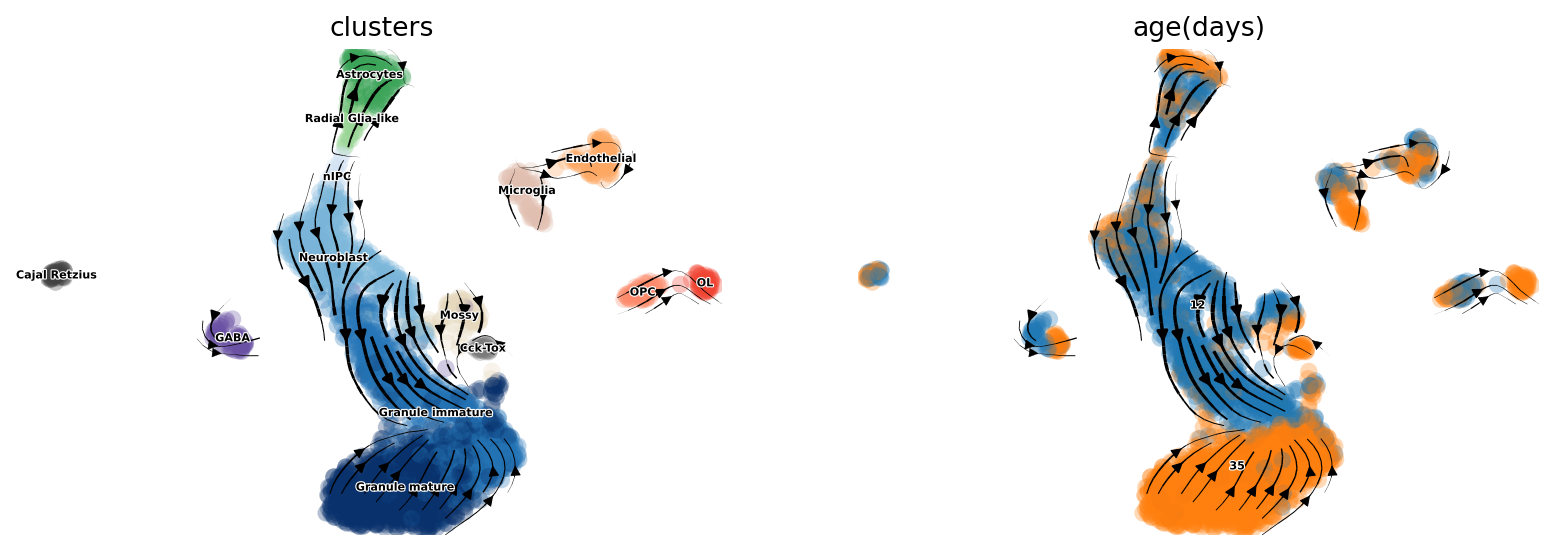

In [19]:
idx = (np.min(adata_brie.varm['fdr'], axis=1) < 0.05) * (cdr > 0.15)
gene_use = adata_brie.var.index[idx]

print(len(gene_use), sum(brie.match(gene_use, adata.var.index) != None))

scv.tl.velocity_graph(adata, gene_subset=gene_use)
scv.pl.velocity_embedding_stream(adata, basis='umap', 
                                 color=['clusters', 'age(days)'],
                                 legend_fontsize=5, dpi=100)

In [20]:
## Plotting with higher figure resolution 

# scv.pl.velocity_embedding_stream(adata, basis='umap', color=['clusters'], 
#                                  legend_fontsize=5, dpi=150, title='')

# scv.pl.velocity_embedding(adata, basis='umap', arrow_length=2, arrow_size=2, dpi=300, title='')

## scVelo's dynamical model

*Dynamical model*
```Python
adata = scv.datasets.dentategyrus()

scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=3000)
scv.pp.moments(adata, n_pcs=30, n_neighbors=30)

scv.tl.recover_dynamics(adata, var_names='all')
scv.tl.velocity(adata, mode='dynamical')
scv.tl.velocity_graph(adata)
scv.tl.latent_time(adata)
adata.write(dat_dir + "/dentategyrus_scvelo_dyna_3K.h5ad")
```

In [21]:
adata_dyna = scv.read(dat_dir + "/dentategyrus_scvelo_dyna_3K.h5ad")

In [22]:
print(np.sum(adata_dyna.var['velocity_genes']))

1066


computing velocity graph
    finished (0:00:13) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:01) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


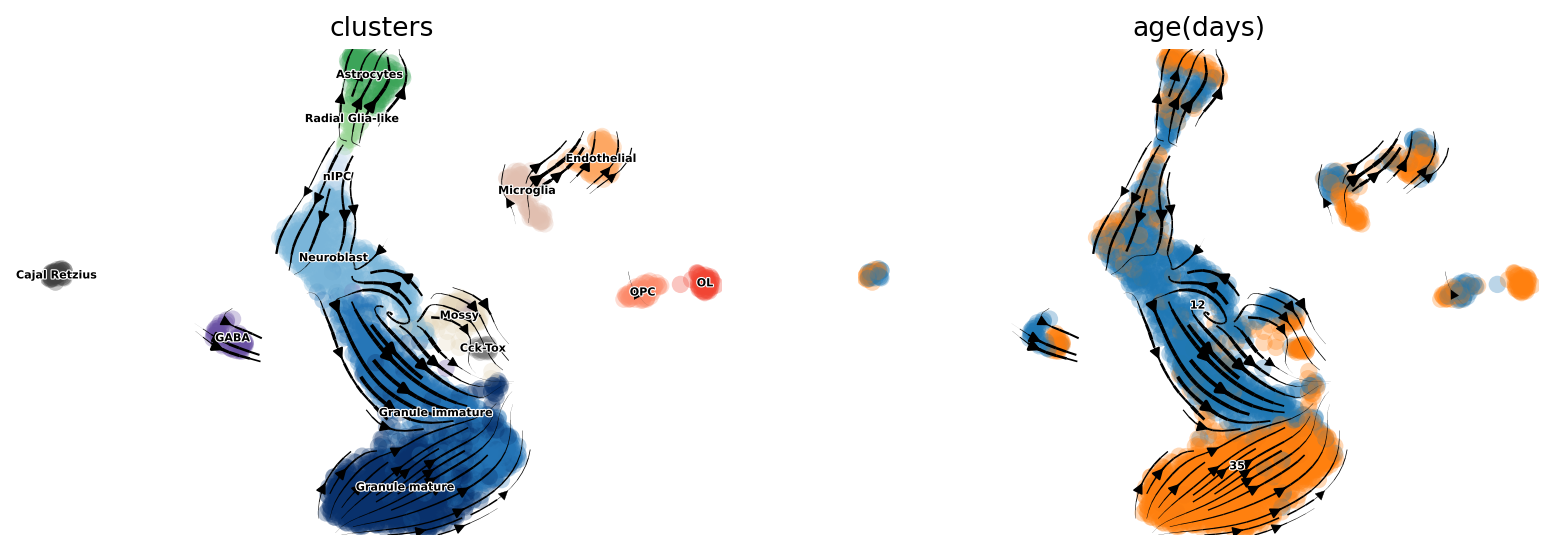

In [23]:
scv.tl.velocity_graph(adata_dyna, gene_subset=None)
scv.pl.velocity_embedding_stream(adata_dyna, basis='umap', 
                                 color=['clusters', 'age(days)'],
                                 legend_fontsize=5)